Permanently connect AOM to the setup. Therefore the PulseStreamer needs to be always on and running.

Notes

- Do not blindly hit run all; ensure that the correct blocks are running
- Restart kernel before re-running code
- Explicit laser off command at the bottom of the page

In [1]:
import numpy as np
import pathlib
import pyvisa
import time
import matplotlib.pyplot as plt
import math
from datetime import datetime
import threading
import pandas as pd
import os

TODAY_STR = datetime.now().strftime("%d.%m.%Y") # Format the date as DD.MM.YYYY
print(f"\x1b[1;3;4;96mDate of running the code:\x1b[0m \x1b[1;3;4;92m{TODAY_STR}\x1b[0m")
print(f"Time of running the code: {datetime.now().strftime("%H:%M:%S")}")
print("\x1b[1;31mWait for it...\x1b[0m")

# Device communication - must always be run
rm = pyvisa.ResourceManager()
list_connections = rm.list_resources()      

# print(list_connections)
# Check device connection
if len(list_connections) != 0:
    print("Pyvisa running nominally")
else:
    raise ValueError("Connections not working")

Date of running the code: 17.12.2024
Time of running the code: 16:08:42
Wait for it...
Pyvisa running nominally


In [2]:
# # Laser connection. Laser is TSL
is_connect_success = False 
while not is_connect_success:
    try:
        TSL = rm.open_resource("TCPIP::169.254.82.30::5000::SOCKET", read_termination="\r")
        print(TSL.query("*IDN?"))
        print("\x1b[0;92mTSL Connection established\x1b[0m")
        is_connect_success = True
    except pyvisa.VisaIOError:
        print("Retrying...")
        time.sleep(0.5)

SANTEC,TSL-570,24070004,0026.0026.0011
TSL Connection established


In [3]:
WAV_START = 1550       # Need transparency
laser_power = 13        # Set to the highest possible value due to significant losses

TSL.write(":WAVelength:SWEep 0")    # Engineering reset to regular, constant-on mode
time.sleep(0.1)
TSL.write(f":WAVelength {WAV_START}nm")
time.sleep(0.1)
TSL.write(f":POW {laser_power}")
time.sleep(0.1)

# print(TSL.query(":POWer:STATe?"))

if TSL.query(":SYSTem:ALERt?") == "No alerts.":
    print("Nominal laser operation")              
    print(f"\x1b[0;92mLaser configured to {WAV_START}nm at {laser_power}dBm, for transparent power transfer\x1b[0m") 
else:
    print(TSL.query(":SYSTem:ALERt?"))
    print("Note that some time might be needed for laser to warm up; See page 101 of TSL manual")

Nominal laser operation
Laser configured to 1550nm at 13dBm, for transparent power transfer


In [4]:
# # oscilloscope connection
# Open the connection to the oscilloscope using its IP address
oscilloscope = rm.open_resource('TCPIP::169.254.112.67::INSTR', open_timeout=5000) # For the RIGOL DHO1204 in A*STAR

# Send a command to verify connection (e.g., identify the instrument)
# Sanity check for successful communication with oscilloscope
response = oscilloscope.query('*IDN?')
print(response, end='')
print("\x1b[0;92mOscilloscope Connection established.\x1b[0m")

RIGOL TECHNOLOGIES,DHO1204,HDO1B261900518,00.02.12
Oscilloscope Connection established.


In [5]:
# # Oscilloscope configure settings
oscilloscope.write(':TIMebase:ROLL 0')      # Turn off roll

# # Sampling rate control
oscilloscope.write(':ACQuire:MDEPth 25M')    
oscilloscope.write(':ACQuire:TYPE NORM')      # Either NORMal or ULTRa, but ULTRa is limited in capability

oscilloscope.write(':CHANnel1:BWLimit 20M')     # Clean up the high frequency noise
oscilloscope.write(':CHANnel1:BWLimit ON')     

# Time scale - this has an effect on sampling!
# timescale = (t_end + buffer * 5) / 5
timescale = 0.004
oscilloscope.write(f':TIMebase:MAIN:SCALe {timescale}')      # This is limited to certain values! Check manual!
oscilloscope.write(':TIMebase:MAIN:OFFSet 0')

# Set voltage scale
oscilloscope.write(':CHANnel1:SCALe 0.5')      
oscilloscope.write(':CHANnel1:OFFSet 0')       # For viewing clarity

oscilloscope.write(':CHANnel1:DISPlay 1')       # 
oscilloscope.write(':CHANnel2:DISPlay 0')       # No need trigger signal here

sampling_rate = float(oscilloscope.query(':ACQuire:SRATe?').strip())

if sampling_rate >= 1e9:
    formatted_rate = f"{sampling_rate / 1e9:.2f} GSa per s"
elif sampling_rate >= 1e6:
    formatted_rate = f"{sampling_rate / 1e6:.2f} MSa per s"
else:
    formatted_rate = f"{sampling_rate:.2f} Sa per s"

print(f"Acquisition mode is set to {oscilloscope.query(':ACQuire:TYPE?').strip()}")
print(f"Filter is set to {oscilloscope.query(':CHANnel1:BWLimit?').strip()}")
print(f"Sampling rate is currently to {formatted_rate} with the other settings in place")

print("\x1b[1;31mCheck or query settings again. Rerun cell if wrong.\x1b[0m")
# print((oscilloscope.query(':ACQuire:SRATe?').strip()))
# print(float(oscilloscope.query(':ACQuire:SRATe?').strip()))

Acquisition mode is set to NORM
Filter is set to 20M
Sampling rate is currently to 500.00 MSa per s with the other settings in place
Check or query settings again. Rerun cell if wrong.


In [6]:
perpetual_on = True        # This is just for the AOM to be like it's not even there if set to True

In [7]:
# # PulseStreamer connection - for permanent AOM on
# import API classes into the current namespace
from pulsestreamer import PulseStreamer, Sequence
# Connect to Pulse Streamer
ip = '169.254.8.2'  # Do not change this!!
ps = PulseStreamer(ip)  

# Create a sequence object
sequence = ps.createSequence()

# # on-off sequence creation
# Each time unit is 10**(-9) seconds
# Example: A pulse with 10µs (10000 units) HIGH (or 1) and 30µs (30000 units) LOW (or 0) levels

# Time period of one cycle in seconds, e.g. 1*10**(-6) is one microsecond
T = 0.05         # modify this according to what I want

# Duty ratio (fraction of on-time during one cycle). A float from 0 to 1.
D = 0.5       # modify this according to what I want

if perpetual_on is True:
    D = 1
    # print()
    print("\x1b[1;31mThe AOM is permanently on, so it's like it's not there\x1b[0m")
else:
    print(f"\x1b[1;31mThe AOM has a duty cycle {D} and time period of {T}s\x1b[0m")
    
if D > 1 or D < 0:
    raise ValueError("D must be between 0 and 1, inclusive.")

# Convert T into time units
pattern_T = math.ceil(T / (10**(-9)))
on_time = math.ceil(pattern_T * D)
off_time = math.ceil(pattern_T * (1-D))

pattern = [(on_time, 1), (off_time, 0)]

# Create sequence and assign pattern to digital channel 0
sequence.setDigital(0, pattern)

## Pattern implementation
# Stream the sequence and repeat it indefinitely
n_runs = PulseStreamer.REPEAT_INFINITELY
ps.stream(sequence, n_runs)

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
The AOM is permanently on, so it's like it's not there


In [8]:
# # Data collection of optical absorption

waveforms = {}      # Initialise empty dictionary of waveforms for the plot_and_save_waveform function   

def plot_and_save_waveform(ch=1):
    """Function to save the waveform as CSV file. """
   
    # Select the channel
    oscilloscope.write(f':WAV:SOUR CHAN{ch}')

    # Set the waveform format to ASCII (can also use 'BYTE' or 'WORD' for binary)
    oscilloscope.write(':WAV:FORM ASCII')

    # Get the waveform data
    print(f"Querying waveform data for channel {ch}")
    data = oscilloscope.query(':WAV:DATA?')

    # Parse the data (it's returned as a comma-separated string in ASCII mode)
    waveform_data = np.array([float(i) for i in data.split(',')])
    waveforms[f"waveform_ch{ch}"] = waveform_data

    # Get the X-axis scale and position (Time per division, etc.)
    x_increment = float(oscilloscope.query(':WAV:XINC?'))
    x_origin = float(oscilloscope.query(':WAV:XOR?'))

    # Generate the time axis
    time_axis = np.linspace(x_origin, x_origin + x_increment * len(waveform_data), len(waveform_data))
    waveforms[f"time_axis_ch{ch}"] = time_axis

    # Generate a timestamp for the file name
    timestamp = datetime.now().strftime("%d.%m.%Y_%H.%M.%S")
    # Generate a datestamp for the overall folder name
    datestamp = datetime.now().strftime("%d.%m.%Y")
    
    # Define the folder path
    output_folder = f"C:/Users/groov/VSCode/CSV_Waveforms/{datestamp}/{datestamp}_cooldown_fault_check"
    # Create the folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    csvfilename = os.path.join(output_folder, f"{timestamp}_optical_at_{WAV_START}nm.csv")
    # opticalcsvfilenames.append(csvfilename)

    # Save the waveform data to a CSV file
    np.savetxt(csvfilename, np.column_stack((time_axis, waveform_data)), delimiter=",", header="Time, Amplitude")

    # Plot the waveform for visualization and sanity check
    plt.figure(figsize=(10, 6))
    plt.plot(waveforms[f"time_axis_ch{ch}"],  waveforms[f"waveform_ch{ch}"], label=f"channel {ch}")
    plt.title(f"Optical transfer curve at wavelength {WAV_START}nm")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (V)")
    plt.ylim(bottom=0)  # Ensure x-axis is visible
    plt.grid(True)
    plt.legend()
    # plt.savefig(f"waveform_channel_{channel}_{timestamp}.png")
    plt.show()

print("Functions defined")

Functions defined


Querying waveform data for channel 1


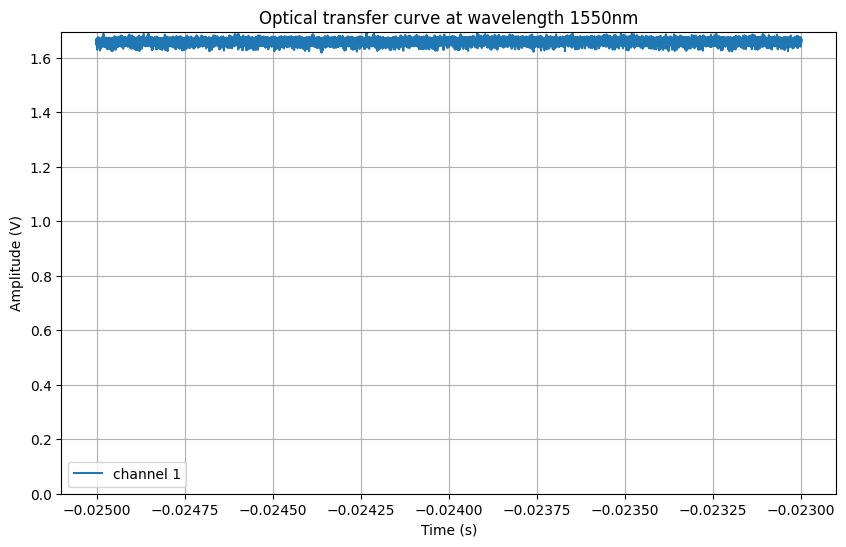

In [ ]:
# Monitor the signal
initial_time_since_epoch = time.time()

while time.time() - initial_time_since_epoch <= 24*60*60:
    #  Turn on laser to constant on mode
    TSL.write(":WAVelength:SWEep 0")
    time.sleep(0.1)
    TSL.write(f":WAVelength {WAV_START}nm")
    time.sleep(0.1)     
    TSL.write(":POWer:STATe 0") # Engineering reset
    time.sleep(0.1)
    TSL.write(":POWer:STATe 1")
    time.sleep(0.1)

    oscilloscope.write(':STOP') # Quickly "engineering reset" the oscilloscope
    time.sleep(0.1)   # Small delay to let oscilloscope settle before running and arming trigger
    # print("Oscilloscope reset and running")

    oscilloscope.write(':RUN') # Need oscilloscope to start running before it can capture anything
    time.sleep(0.1)   # The trigger will automatically start capturing once the trigger is detected
    # print("Oscilloscope still running")

    plot_and_save_waveform()

    print("Wait 5 minutes before next reading")
    time.sleep(5*60)        # Measure the optical power every 5 minutes

In [ ]:
# # Explicit laser turn off
if TSL.query(":POWer:STATe?") != "+0":
    TSL.write(":POWer:STATe +0")
    time.sleep(0.1)